Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 2: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [15]:
import logging
from pprint import pprint, pformat
from typing import Callable
from collections import namedtuple
import random
from copy import deepcopy
from random import gauss
import matplotlib.pyplot as plt
import random

## The *Nim* and *Nimply* classes

In [16]:
NUM_ROWS = 5
K = None
NUM_MATCHES = 300
λ = 20
σ = 0.1
GENERATION_SIZE = 100 // λ
random.seed(42)


In [17]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [18]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        # Initialize the Nim object with given number of rows and an optional maximum object limit
        self._rows = [i * 2 + 1 for i in range(num_rows)]   # Create a list of odd numbers as row sizes
        self._k = k   # Store the maximum object limit

    def __bool__(self):
        # Return True if there are objects remaining in the game, False otherwise
        return sum(self._rows) > 0

    def __str__(self):
        # Return a string representation of the object
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        # Return the rows as a tuple
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        # Perform a nimming move by removing objects from a specified row
        row, num_objects = ply   # Unpack the tuple
        assert self._rows[row] >= num_objects   # Check if the specified row has enough objects
        assert self._k is None or num_objects <= self._k   # Check if the number of objects is within the maximum limit
        self._rows[row] -= num_objects   # Subtract the number of objects from the specified row



## Sample (and silly) startegies 

In [19]:

def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    # Select a row that has at least one object remaining
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    # Randomly choose a number of objects to remove from the selected row
    num_objects = random.randint(1, state.rows[row])
    # Create and return a Nimply object representing the chosen move
    return Nimply(row, num_objects)



In [20]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    # Generate a list of possible moves
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    # Select the move with the maximum number of objects from the lowest row
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))



In [21]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


In [22]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## Oversimplified match

In [23]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, pure_random)

nim = Nim(5) # define the game with 5 rows
logging.info(f"init : {nim}")
player = 0
while nim: # while the game is not over --> sum of all rows is not zero
    ply = strategy[player](nim) # get the move from the player 0
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply) # perform the move
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")


INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=5)
INFO:root:status: <1 3 5 7 4>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 5 7 4>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=2)
INFO:root:status: <0 3 5 5 4>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=2)
INFO:root:status: <0 3 3 5 4>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=2)
INFO:root:status: <0 3 1 5 4>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=3)
INFO:root:status: <0 0 1 5 4>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=3)
INFO:root:status: <0 0 1 5 1>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=1)
INFO:root:status: <0 0 0 5 1>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 0 0 4 1>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 0 0 3 1>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 0

## (1+λ)-ES

In [24]:
def state_info(state: Nim) -> dict:
    info = dict()
    info["possible_moves"] = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1) 
    ]
    info["active_rows_number"] = sum(o > 0 for o in state.rows)
    info["shortest_row"] = min((x for x in enumerate(state.rows) if x[1] > 0), key=lambda y: y[1])[0]
    info["longest_row"] = max((x for x in enumerate(state.rows)), key=lambda y: y[1])[0]
    info["random_row"] = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    info["nim_sum"] = nim_sum(state)

    brute_force = list()
    for m in info["possible_moves"]:
        tmp = deepcopy(state)
        tmp.nimming(m)
        brute_force.append((m, nim_sum(tmp)))
    info["brute_force"] = brute_force

    return info

In [25]:
def evolved_strategy(genome: float) -> Callable:
    def adaptive(state: Nim) -> Nimply:
        data = state_info(state)

        if random.random() < genome:
            ply = Nimply(data["shortest_row"], random.randint(1, state.rows[data["shortest_row"]]))
        else:
            ply = Nimply(data["longest_row"], random.randint(1, state.rows[data["longest_row"]]))
        
        return ply
        
    
    
        # if genome > 0.66:
        #     ply = Nimply(data["longest_row"], random.randint(1, state.rows[data["longest_row"]]))
        # elif  genome > 0.33:
        #     ply = Nimply(data["shortest_row"], random.randint(1, state.rows[data["shortest_row"]]))
        # else: 
        #     ply = Nimply(data["random_row"], random.randint(1, state.rows[data["random_row"]]))
        # return ply

    return adaptive

In [26]:
def fitness(strategy: Callable) -> int:
    won = 0
    opponent = (strategy, optimal)

    for _ in range(NUM_MATCHES):
        nim = Nim(NUM_ROWS)
        player = 0

        while nim:
            ply = opponent[player](nim)
            nim.nimming(ply)  # perform the move
            player ^= 1

        if player == 0:
            won += 1

    return won  # return the number of matches won

In [27]:


def generate_offsprings(offspring) -> list:
    
    offsprings = [np.clip(offspring + np.random.normal(0, σ), 0, 1) for _ in range(λ)]
    
    
    return offsprings


[(0.4492090462838536, 97),
 (0.5101723593555982, 94),
 (0.5227544571453957, 93),
 (0.3448662974234163, 93),
 (0.4801951654981371, 92),
 (0.37512131697974094, 92),
 (0.6726990317292566, 91),
 (0.38650637346708205, 90),
 (0.559790379939833, 90),
 (0.5980612529943687, 89),
 (0.34333267478123336, 88),
 (0.38994938122584455, 87),
 (0.5538595077981359, 86),
 (0.651978658127726, 83),
 (0.4080251951713245, 82),
 (0.5774164570904936, 77),
 (0.5147745594743547, 74),
 (0.5033987015702802, 73),
 (0.4728085436093916, 73),
 (0.6439185011499506, 72),
 (0.6638007707061494, 67)]
Best result for generation 1 is: (0.4492090462838536, 97)
[(0.29763904548709413, 106),
 (0.5798712044649644, 103),
 (0.2520783848097281, 100),
 (0.4451747027816157, 96),
 (0.42189088831923954, 95),
 (0.425836554371866, 93),
 (0.4503010813948189, 93),
 (0.4492090462838536, 92),
 (0.5563907636515557, 90),
 (0.43367425386495617, 90),
 (0.46134305186153285, 90),
 (0.39335079512392873, 89),
 (0.6090436458270316, 86),
 (0.46700367220

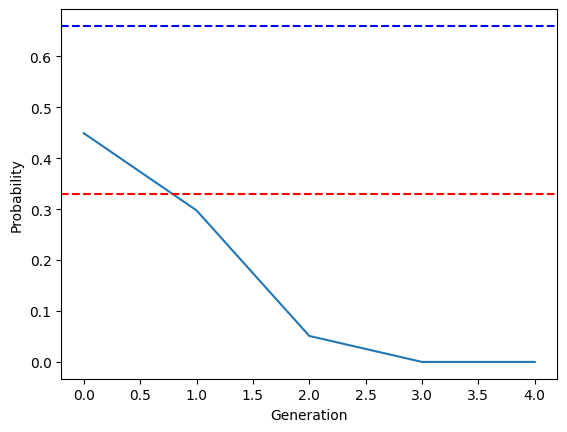

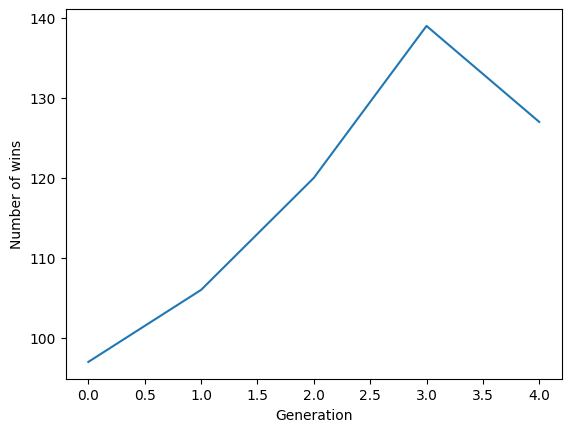

In [28]:
current_solution = random.random()
choosen_probability = list()
solutions_list = list()
# stats = [0, 0]
for n in range(GENERATION_SIZE):
    # offspring <- select λ random points mutating the current solution
    # print("Starting probability for generation", n+1, "is:", current_solution)
    offsprings = generate_offsprings(current_solution)
    offsprings.append(current_solution)
    # evaluate and select best
    evals = [
        (offspring, fitness(evolved_strategy(offspring))) for offspring in offsprings
    ]

    # for i in range(λ):
    #         if evals[i][1] > evals[λ-1][1]:
    #             stats[1] += 1

    evals.sort(key=lambda x: x[1], reverse=True)
    pprint(evals)

    current_solution = evals[0][0]
    choosen_probability.append(current_solution)
    solutions_list.append(evals[0][1])

    print(f"Best result for generation {n+1} is:", evals[0])


plt.plot(range(len(choosen_probability)), choosen_probability)
plt.axhline(y=0.33, color="r", linestyle="--")
plt.axhline(y=0.66, color="b", linestyle="--")
plt.xlabel("Generation")
plt.ylabel("Probability")
plt.show()

plt.plot(range(GENERATION_SIZE), solutions_list)
plt.xlabel("Generation")
plt.ylabel("Number of wins")
plt.show()


# if state.k is None or o <= state.k

## (1,λ)-ES

[(0.8373390724338918, 84),
 (0.7958891731080656, 83),
 (0.9749052886371381, 83),
 (0.8859083977594154, 82),
 (0.8679305663749073, 82),
 (0.8827829469024293, 80),
 (1.0, 80),
 (1.0, 79),
 (0.9278144432054917, 78),
 (1.0, 77),
 (0.9981111368349845, 75),
 (1.0, 74),
 (0.9514467002122724, 74),
 (0.7310460223126958, 73),
 (1.0, 72),
 (0.8913386274793988, 72),
 (0.9616781909292365, 71),
 (0.9541258954518135, 71),
 (0.8367077225882771, 70),
 (0.9083137886234949, 66)]
Best result for generation 1 is: (0.8373390724338918, 84)
[(0.7520805094493003, 88),
 (0.8093327722605196, 85),
 (0.8686700215192208, 85),
 (0.8463428966103804, 84),
 (0.8607244579544329, 83),
 (0.8227910184632169, 82),
 (0.9648705883564985, 82),
 (0.8723651086748689, 80),
 (0.7331080080986974, 80),
 (0.7066440341406958, 79),
 (0.7746176051465341, 79),
 (0.8775161111721316, 78),
 (0.8132768890319405, 77),
 (0.687006082448419, 77),
 (0.9293263491970594, 77),
 (0.8462816546341848, 76),
 (0.8628064055181428, 72),
 (0.875268608122681

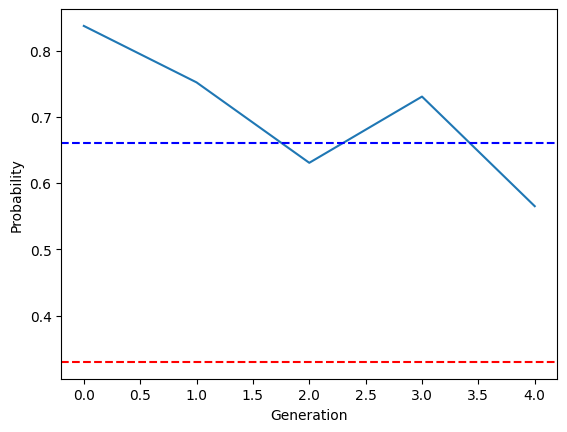

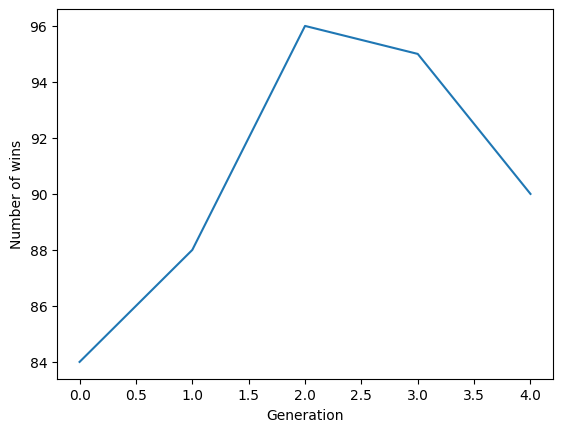

In [29]:
current_solution = random.random()
choosen_probability = list()
solutions_list = list()

for n in range(GENERATION_SIZE):
    # offspring <- select λ random points mutating the current solution
    # print("Starting probability for generation", n+1, "is:", current_solution)
    offsprings = generate_offsprings(current_solution)

    # evaluate and select best
    evals = [
        (offspring, fitness(evolved_strategy(offspring))) for offspring in offsprings
    ]


    evals.sort(key=lambda x: x[1], reverse=True)
    pprint(evals)

    current_solution = evals[0][0]
    choosen_probability.append(current_solution)
    solutions_list.append(evals[0][1])

    print(f"Best result for generation {n+1} is:", evals[0])


plt.plot(range(len(choosen_probability)), choosen_probability)
plt.axhline(y=0.33, color="r", linestyle="--")
plt.axhline(y=0.66, color="b", linestyle="--")
plt.xlabel("Generation")
plt.ylabel("Probability")
plt.show()

plt.plot(range(GENERATION_SIZE), solutions_list)
plt.xlabel("Generation")
plt.ylabel("Number of wins")
plt.show()


# if state.k is None or o <= state.k